In [1]:
!pwd
import os
os.chdir('..')
!pwd

/home/cber/Projects/hybrid-hmm/notebooks
/home/cber/Projects/hybrid-hmm


In [2]:
import numpy as np
import tensorflow as tf
import pandas as pd
import scipy.io as sio
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score


In [3]:
def get_center_values(state_seq, sampling_rate=50):
    centers = []
    prev_start = 0 # start of the initial state
    for i in range(1, len(state_seq)):
        if state_seq[i] != state_seq[i - 1]:
            center = prev_start + i # aggregation for average between the end of last and start of new
            centers.append([(center / sampling_rate) / 2, state_seq[i - 1]])  # save mean and previous state
            prev_start = i  # the new becomes the previous
    return centers


def schmidt_metrics(ground_truth, prediction, limit_tp=0.06):
    center_value = np.array(get_center_values(ground_truth))
    est_center_value = np.array(get_center_values(prediction))

    tp, fp = 0, 0
    for k in range(len(est_center_value)):
        out_center = est_center_value[k, 0]
        out_state = est_center_value[k, 1]
        distance = np.abs(out_center - center_value[:, 0])
        candidates = np.where(distance <= limit_tp)
        sum_condition_1 = np.sum(center_value[candidates, 1] == 1)
        sum_condition_2 = np.sum(center_value[candidates, 1] == 3)
        if out_state == 1 and sum_condition_1 > 0:
            tp += 1
        if out_state == 1 and sum_condition_1 == 0:
            fp += 1
        if out_state == 3 and sum_condition_2 > 0:
            tp += 1
        if out_state == 3 and sum_condition_2 == 0:
            fp += 1
       
    try:
        ppv = tp / (tp + fp)
    except:
        ppv = 0.0
    try:
        sensitivity = tp / (len(np.where(center_value[:, 1] == 1)[0]) + len(np.where(center_value[:, 1] == 3)[0]))
    except:
        sensitivity = 0.0
    return ppv, sensitivity

def schmidt_fold(gt, _h_vit):
    n_folds = gt.shape[0]
    mean_fold_ppv = []
    mean_fold_sensitivity = []
    for fold in range(n_folds):
        n_sounds = gt[fold].shape[0]
        ppv, sensitivity = [], []
        for sound in range(n_sounds):
            ppv_, sensitivity_ = schmidt_metrics(gt[fold][sound], _h_vit[fold][sound])
            ppv.append(ppv_)
            sensitivity.append(sensitivity_)
        mean_fold_ppv.append(np.mean(ppv))
        mean_fold_sensitivity.append(np.mean(sensitivity))

    return mean_fold_ppv, mean_fold_sensitivity

In [4]:
def read_results(path: str):
    gt = sio.loadmat(path + '/ground_truth.mat', squeeze_me=True)['ground_truth']
    cnn = sio.loadmat(path + '/out_seq.mat', squeeze_me=True)['out_seq']
    vit = sio.loadmat(path + '/viterbi.mat', squeeze_me=True)['viterbi']
    return gt, cnn, vit

In [5]:
def get_accuracy(gt, cnn, n_folds=10):
    acc_folds = []
    for fold in range(n_folds):
        accuracy = []
        for sound in range(len(gt[fold])):
            try:
                accuracy.append(accuracy_score(gt[fold][sound], cnn[fold][sound]))
            except:
                print("fold", fold, "sound", sound, " ", gt[fold][sound].shape, cnn[fold][sound].shape)
                pass
        acc_folds.append(np.mean(accuracy))
    return acc_folds

In [6]:

def metrics_model(path: str):
    gt, cnn, vit = read_results(path)
    accuracy = get_accuracy(gt, vit)
    ppv, sensitivity = schmidt_fold(gt, vit)
    return accuracy, ppv, sensitivity

In [91]:
# Hybrid gradients_physionet16_cnn_envelograms_only 
ph16_hybrid_cnn_env = metrics_model('results/hybrid/hmm_gradshybrid_envelograms_physio16_10fold/2022-02-25_08:33:40')
ph16_crosse_unet_env = metrics_model('results/unet/unet/2022-02-26_07:49:39')
ph16_hybrid_cnn_psd = metrics_model('results/hybrid/hmm_gradshybrid_psd_physio16_10fold/2022-03-08_18:16:35')
ph16_true_hybrid_cnn_env = metrics_model('results/hybrid/hmm_mmi_physio16_envelops_joint/2022-03-17_13:51:45')
ph16_completemmi_hybrid_cnn_env = metrics_model('results/hybrid/hmm_completemmi_physio16_envelops_joint/2022-03-18_14:03:27')
ph16_completelikelihood_hybrid_cnn_env = metrics_model('results/hybrid/hmm_completlikelihood1e3_physio16_envelops_joint/2022-03-20_12:55:33')
ph16_completelikelihood_hybrid_cnn_psd = metrics_model('results/hybrid/hmm_completlikelihood1e3_physio16_psd_joint/2022-03-21_15:58:21')
ph16_completelikelihood_hybrid_cnn_mfcc = metrics_model('results/hybrid/hmm_completlikelihood1e3_physio16_mfcc_joint/2022-05-03_10:09:45') 
ph16_fernado_mfcc_joint = metrics_model('results/fernando/fernando_CE_physio16_mfcc_joint/2022-05-02_09:40:01')

# Fine-tune HMM gradients only 
ph16_psd_fine_tune_hmm20 = metrics_model('results/hybrid/fine_tune/hmm_completlikelihood1e3_physio16_psd_joint/2022-05-04_14:56:00')

# 

In [114]:
! ls results/hybrid/hmm_only_completlikelihood1e3_physio16_psd_joint/2022-04-22_09:26:46

checkpoint				p_states_fold_1.npy
cnn_weights_fold_0.data-00000-of-00001	p_states_fold_2.npy
cnn_weights_fold_0.index		p_states_fold_3.npy
cnn_weights_fold_1.data-00000-of-00001	p_states_fold_4.npy
cnn_weights_fold_1.index		p_states_fold_5.npy
cnn_weights_fold_2.data-00000-of-00001	p_states_fold_6.npy
cnn_weights_fold_2.index		p_states_fold_7.npy
cnn_weights_fold_3.data-00000-of-00001	p_states_fold_8.npy
cnn_weights_fold_3.index		p_states_fold_9.npy
cnn_weights_fold_4.data-00000-of-00001	p_states.mat
cnn_weights_fold_4.index		test_indexes.mat
cnn_weights_fold_5.data-00000-of-00001	train_indexes.mat
cnn_weights_fold_5.index		trans_mat_fold_0.npy
cnn_weights_fold_6.data-00000-of-00001	trans_mat_fold_1.npy
cnn_weights_fold_6.index		trans_mat_fold_2.npy
cnn_weights_fold_7.data-00000-of-00001	trans_mat_fold_3.npy
cnn_weights_fold_7.index		trans_mat_fold_4.npy
cnn_weights_fold_8.data-00000-of-00001	trans_mat_fold_5.npy
cnn_weights_fold_8.index		trans_mat_fold_6.npy
cnn_weights_fold_9.data-00

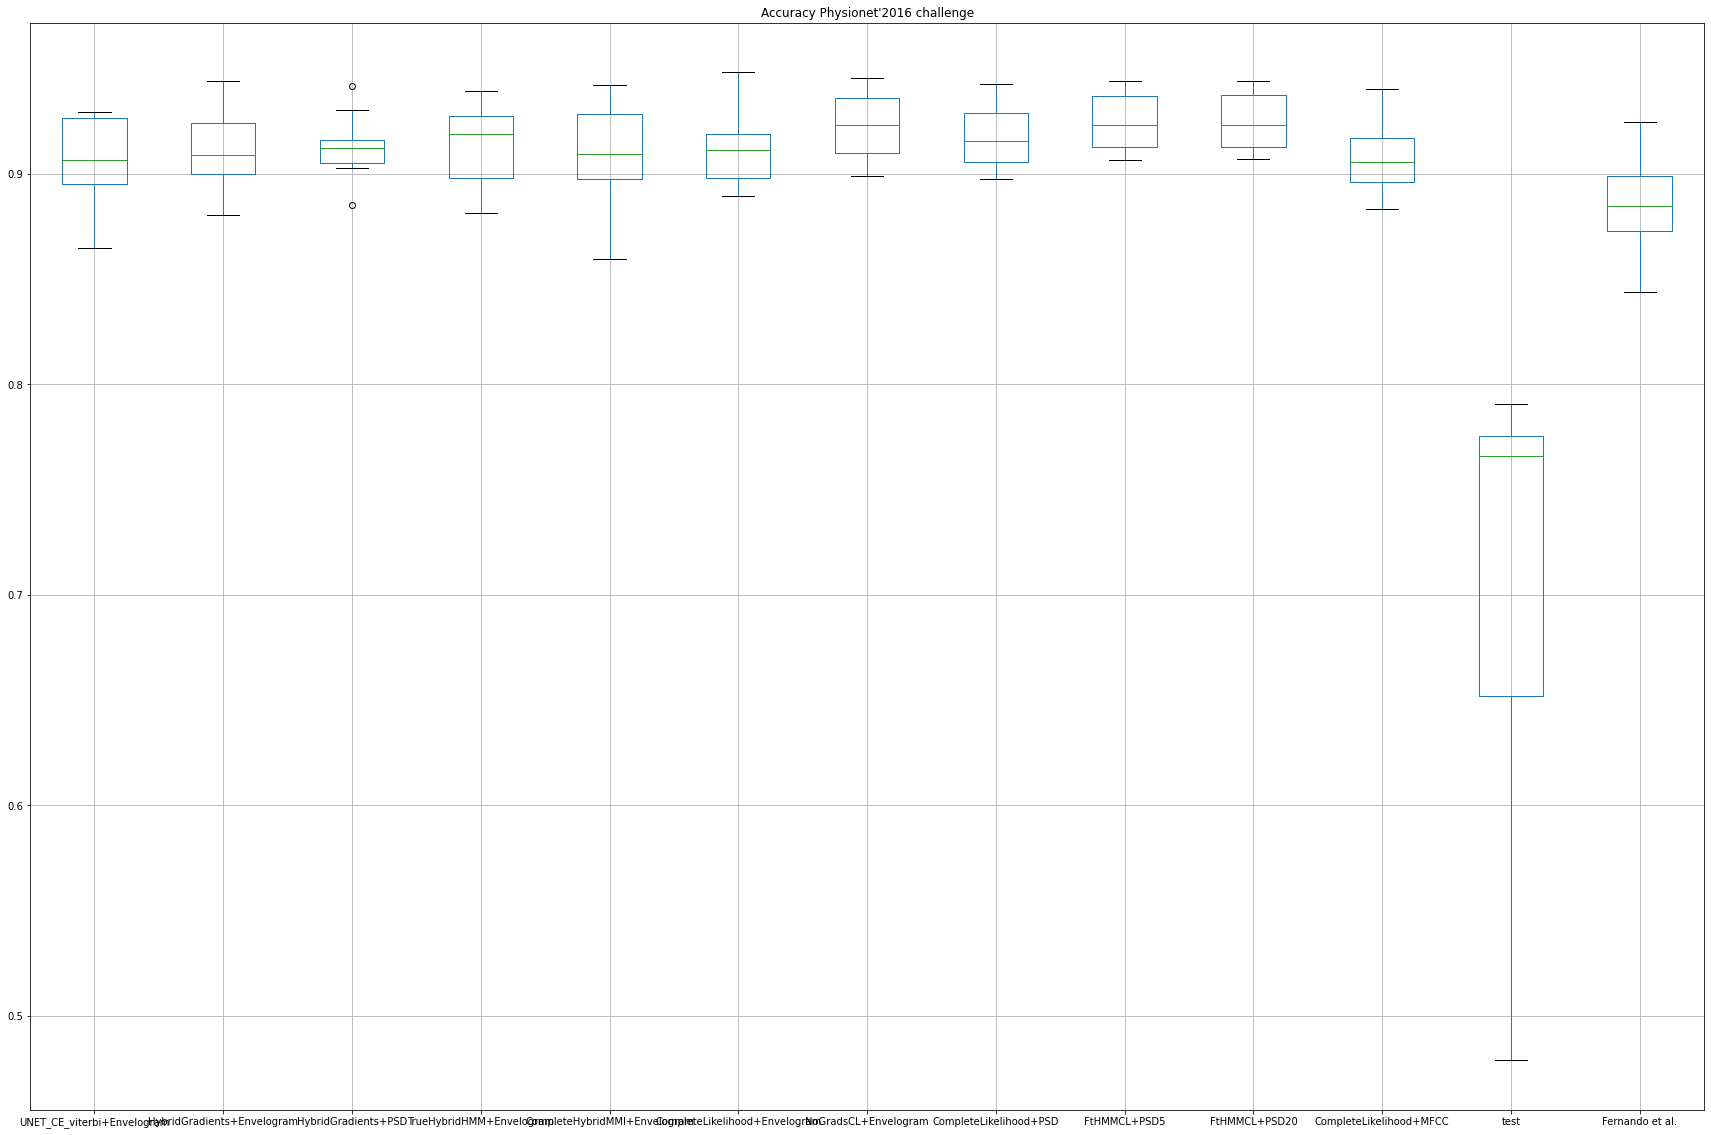

In [99]:
df = pd.DataFrame({'UNET_CE_viterbi+Envelogram': ph16_crosse_unet_env[0],
                   'HybridGradients+Envelogram': ph16_hybrid_cnn_env[0],
                   'HybridGradients+PSD': ph16_hybrid_cnn_psd[0],
                   'TrueHybridHMM+Envelogram': ph16_true_hybrid_cnn_env[0],
                   'CompleteHybridMMI+Envelogram': ph16_completemmi_hybrid_cnn_env[0],
                   'CompleteLikelihood+Envelogram':ph16_completelikelihood_hybrid_cnn_env[0],
                   'NoGradsCL+Envelogram': ph16_completelikelihood_nograds_cnn_env[0], 
                   'CompleteLikelihood+PSD': ph16_completelikelihood_hybrid_cnn_psd[0],
                   'FtHMMCL+PSD20': ph16_psd_fine_tune_hmm20[0],
                   'CompleteLikelihood+MFCC': ph16_completelikelihood_hybrid_cnn_mfcc[0],
                   'Fernando et al.': ph16_fernado_mfcc_joint[0],
                   })

boxplot = df.boxplot(column=list(df.keys()), figsize=(30,20))
plt.title('Accuracy Physionet\'2016 challenge')
plt.show()

In [100]:
df = pd.DataFrame({'UNET_CE_viterbi+Envelogram': ph16_crosse_unet_env[1],
                   'HybridGradients+Envelogram': ph16_hybrid_cnn_env[1],
                   'HybridGradients+PSD': ph16_hybrid_cnn_psd[1],
                   'TrueHybridHMM+Envelogram': ph16_true_hybrid_cnn_env[1],
                   'CompleteHybridMMI+Envelogram': ph16_completemmi_hybrid_cnn_env[1],
                   'CompleteLikelihood+Envelogram':ph16_completelikelihood_hybrid_cnn_env[1],
                   'NoGradsCL+Envelogram': ph16_completelikelihood_nograds_cnn_env[1], 
                   'CompleteLikelihood+PSD': ph16_completelikelihood_hybrid_cnn_psd[1],
                   'FtHMMCL+PSD20': ph16_psd_fine_tune_hmm20[1],
                   'CompleteLikelihood+MFCC': ph16_completelikelihood_hybrid_cnn_mfcc[1],
                   'NoGradsCL+PSD': ph16_completelikelihood_nograds_cnn_psd[1], 
                   'Fernando et al.': ph16_fernado_mfcc_joint[1],
                   })

boxplot = df.boxplot(column=list(df.keys()), figsize=(30,20))
plt.title('PPV Physionet\'2016 challenge')
plt.show()

SyntaxError: invalid syntax (3494490954.py, line 13)

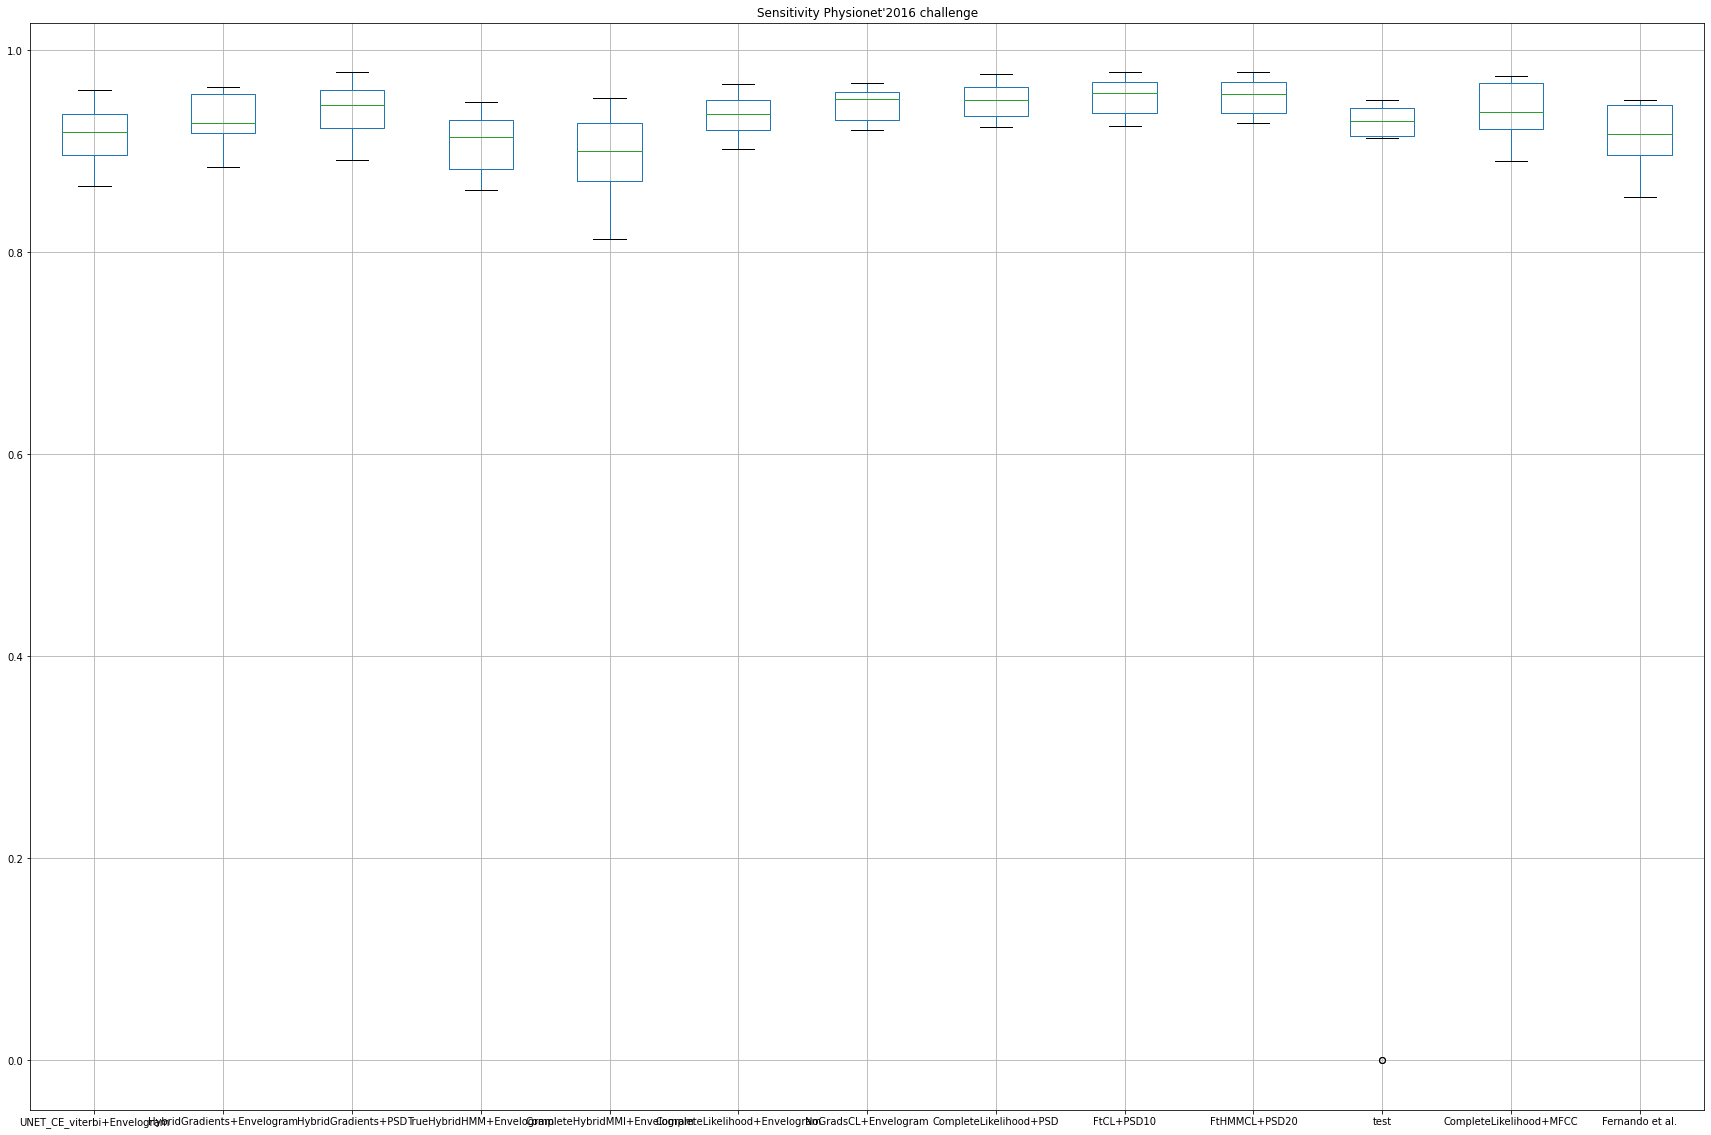

In [101]:
df = pd.DataFrame({'UNET_CE_viterbi+Envelogram': ph16_crosse_unet_env[2],
                   'HybridGradients+Envelogram': ph16_hybrid_cnn_env[2],
                   'HybridGradients+PSD': ph16_hybrid_cnn_psd[2],
                   'TrueHybridHMM+Envelogram': ph16_true_hybrid_cnn_env[2],
                   'CompleteHybridMMI+Envelogram': ph16_completemmi_hybrid_cnn_env[2],
                   'CompleteLikelihood+Envelogram':ph16_completelikelihood_hybrid_cnn_env[2],
                   'NoGradsCL+Envelogram': ph16_completelikelihood_nograds_cnn_env[2], 
                   'CompleteLikelihood+PSD': ph16_completelikelihood_hybrid_cnn_psd[2],
                   'FtHMMCL+PSD20': ph16_psd_fine_tune_hmm20[2],
                   'CompleteLikelihood+MFCC': ph16_completelikelihood_hybrid_cnn_mfcc[2],
                   'Fernando et al.': ph16_fernado_mfcc_joint[1],
                   })

boxplot = df.boxplot(column=list(df.keys()), figsize=(30,20))
plt.title('Sensitivity Physionet\'2016 challenge')
plt.show()

In [21]:
!ls results/hybrid/hmm_completlikelihood1e3_physio16_envelops_joint/2022-03-20_12:55:33

checkpoint				p_states_fold_1.npy
cnn_weights_fold_0.data-00000-of-00001	p_states_fold_2.npy
cnn_weights_fold_0.index		p_states_fold_3.npy
cnn_weights_fold_1.data-00000-of-00001	p_states_fold_4.npy
cnn_weights_fold_1.index		p_states_fold_5.npy
cnn_weights_fold_2.data-00000-of-00001	p_states_fold_6.npy
cnn_weights_fold_2.index		p_states_fold_7.npy
cnn_weights_fold_3.data-00000-of-00001	p_states_fold_8.npy
cnn_weights_fold_3.index		p_states_fold_9.npy
cnn_weights_fold_4.data-00000-of-00001	p_states.mat
cnn_weights_fold_4.index		test_indexes.mat
cnn_weights_fold_5.data-00000-of-00001	train_indexes.mat
cnn_weights_fold_5.index		trans_mat_fold_0.npy
cnn_weights_fold_6.data-00000-of-00001	trans_mat_fold_1.npy
cnn_weights_fold_6.index		trans_mat_fold_2.npy
cnn_weights_fold_7.data-00000-of-00001	trans_mat_fold_3.npy
cnn_weights_fold_7.index		trans_mat_fold_4.npy
cnn_weights_fold_8.data-00000-of-00001	trans_mat_fold_5.npy
cnn_weights_fold_8.index		trans_mat_fold_6.npy
cnn_weights_fold_9.data-00

In [35]:
!ls results/unet/unet/2022-02-26_07:49:39

ground_truth.mat     test_indexes.mat	   viterbi.mat
out_seq.mat	     train_indexes.mat	   weights_fold0.hdf5
p_states_fold_0.npy  trans_mat_fold_0.npy  weights_fold1.hdf5
p_states_fold_1.npy  trans_mat_fold_1.npy  weights_fold2.hdf5
p_states_fold_2.npy  trans_mat_fold_2.npy  weights_fold3.hdf5
p_states_fold_3.npy  trans_mat_fold_3.npy  weights_fold4.hdf5
p_states_fold_4.npy  trans_mat_fold_4.npy  weights_fold5.hdf5
p_states_fold_5.npy  trans_mat_fold_5.npy  weights_fold6.hdf5
p_states_fold_6.npy  trans_mat_fold_6.npy  weights_fold7.hdf5
p_states_fold_7.npy  trans_mat_fold_7.npy  weights_fold8.hdf5
p_states_fold_8.npy  trans_mat_fold_8.npy  weights_fold9.hdf5
p_states_fold_9.npy  trans_mat_fold_9.npy
p_states.mat	     trans_mat.mat


checkpoint				p_states_fold_9.npy
cnn_weights_fold_9.data-00000-of-00001	trans_mat_fold_9.npy
cnn_weights_fold_9.index


In [49]:
ph16_psd_fine_tune[0]

[0.9424723308425007,
 0.9139681549630443,
 0.9090013064549519,
 0.9046947837434861,
 0.9199720036132132,
 0.9355028798993885,
 0.902809612539048,
 0.8986078862113112,
 0.9321515032399886,
 0.9176239631130962]

In [64]:
ph16_psd_fine_tune2[0]

[0.9440058102625828,
 0.9167672863853408,
 0.911459534244759,
 0.9045036074252756,
 0.9220526781554339,
 0.935743843855557,
 0.9044345684746379,
 0.904341853046613,
 0.9371651486616579,
 0.9200902152314427]

In [102]:
ph16_psd_ft_hmm_cnn[2]

[0.944891985617792,
 0.9380172275482698,
 0.9202346798455663,
 0.9378054850629953,
 0.950561427240707,
 0.947666327926925,
 0.0,
 0.9133502590821916,
 0.0,
 0.9215491925449841]

In [111]:
np.sum(ph16_psd_ft_hmm_cnn[1]) / 8

0.9595787249562252

In [ ]:
0.944891985617792,
 0.9380172275482698,
 0.9202346798455663,
 0.9378054850629953,
 0.950561427240707,
 0.947666327926925,
 0.0,
 0.9133502590821916,
 0.0,
 0.9215491925449841